In [1]:
# this notebook is to dev adversarial attacks vs a network
# https://blog.ycombinator.com/how-adversarial-attacks-work/

In [2]:
from __future__ import print_function

In [3]:
import matplotlib as mpl
# set this 'backend' when using jupyter; do this before importing pyplot
mpl.use('nbagg')
import matplotlib.pyplot as plt

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

import numpy as np

import sys
sys.path.append('/home/felix/Research/Adversarial Research/FGN---Research/')
import Finite_Gaussian_Network_lib as fgnl
import Finite_Gaussian_Network_lib.fgn_helper_lib as fgnh

In [5]:
!gpustat

countdown  Sat Aug 17 18:09:39 2019
[0] GeForce GTX 1080 | 41'C,   0 % |  2362 /  8119 MB | felix(559M) felix(685M) felix(553M) felix(553M)
[1] GeForce GTX 1080 | 45'C,   0 % |  5993 /  8118 MB | felix(601M) felix(601M) denys(3955M)


In [6]:
# Define what device we are using
print("CUDA Available: ",torch.cuda.is_available())
use_cuda = True
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")
print("Using device:", device)

# manualy set cuda device
torch.cuda.set_device(1)

CUDA Available:  True
Using device: cuda


In [7]:
# # random seeds
# torch.manual_seed(999)
# np.random.seed(999)

# torch.backends.cudnn.deterministic = True
# torch.cuda.manual_seed_all(999)

In [8]:
# MNIST dataset and dataloader declaration
# transforms does both the conversion from 0-255 to 0-1
# and normalizes by the precomputed mean and std

batch_size = 7000

mnist_train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../../MNIST-dataset', train=True, download=False, 
                   transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))
            ])), 
        batch_size=batch_size, shuffle=False)

mnist_test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../../MNIST-dataset', train=False, download=False, 
                   transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))
            ])), 
        batch_size=batch_size, shuffle=False)

In [9]:
# load data by batch
for cln_data, true_label in mnist_train_loader:
    break
cln_data, true_label = cln_data.to(device), true_label.to(device)

In [10]:
# minimum/maximum pixel value post normalization
min_pix = np.min(cln_data.cpu().numpy())
print("min_pix", min_pix)
max_pix = np.max(cln_data.cpu().numpy())
print("max_pix", max_pix)
# theoritical minimum
print( (0.0/255-0.1307)/0.3081 )
# theoritical maximum
print( (255.0/255-0.1307)/0.3081 )

min_pix -0.42421296
max_pix 2.8214867
-0.424212917884
2.82148653035


In [11]:
# load classic model
classic_model_path = "../Experiments/sample_models/sample_classic_model_noisy_eval_p0.65_full.pth"
classic_model = torch.load(classic_model_path)
classic_model.to(device)

Feedforward_Classic_net(
  (hidden_layers): ModuleList(
    (0): Dropout(p=0.03125)
    (1): Linear(in_features=784, out_features=32, bias=True)
    (2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.03125)
    (4): Linear(in_features=32, out_features=32, bias=True)
    (5): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Dropout(p=0.03125)
  )
  (ib): BatchNorm1d(784, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fl): Linear(in_features=32, out_features=10, bias=True)
)

In [12]:
# test the model
# loss functions for the classic net      
classical_cross_ent_loss = (lambda model,output,target:  F.cross_entropy(output,target.long()))

classic_test_res = fgnh.test(classic_model, mnist_train_loader, classical_cross_ent_loss,
                               pred_func=fgnh.cross_ent_pred_accuracy, verbose=True)

Test set - Average loss: 0.2567, Accuracy: 55337/60000 (92%)


In [13]:
# load fgn model
fgn_model_path = "../Experiments/sample_models/sample_fgn_model_noisy_eval_p0.29_full.pth"
fgn_model = torch.load(fgn_model_path)
fgn_model.to(device)

Feedforward_FGN_net(
  (hidden_layers): ModuleList(
    (0): Dropout(p=0.03125)
    (1): FGN_layer()
    (2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.03125)
    (4): FGN_layer()
    (5): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Dropout(p=0.03125)
  )
  (ib): BatchNorm1d(784, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fl): FGN_layer()
)

In [14]:
# test the model
### Loss Functions for the FGN
fgn_cross_ent_loss = (lambda model,output,target:  F.cross_entropy(output,target.long()))

fgn_test_res = fgnh.test(fgn_model, mnist_train_loader, fgn_cross_ent_loss,
                               pred_func=fgnh.cross_ent_pred_accuracy, verbose=True)

Test set - Average loss: 0.1937, Accuracy: 56252/60000 (94%)


In [15]:
# switch to random eval
fgn_model.set_random_eval(True)
fgn_test_res_random = fgnh.test(fgn_model, mnist_train_loader, fgn_cross_ent_loss,
                               pred_func=fgnh.cross_ent_pred_accuracy, verbose=True)

Test set - Average loss: 0.1937, Accuracy: 56252/60000 (94%)


In [16]:
# set models to eval mode
classic_model.eval()
fgn_model.eval()

Feedforward_FGN_net(
  (hidden_layers): ModuleList(
    (0): Dropout(p=0.03125)
    (1): FGN_layer()
    (2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.03125)
    (4): FGN_layer()
    (5): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Dropout(p=0.03125)
  )
  (ib): BatchNorm1d(784, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fl): FGN_layer()
)

In [17]:
### start of copied code

In [18]:
# Starting with all necessary imports

# import torch
# from torch import nn
from torch.autograd import Variable
from torch.autograd.gradcheck import zero_gradients
# import torchvision.transforms as T
# from torchvision.models.inception import inception_v3
# from PIL import Image
# import matplotlib.pyplot as plt
# import numpy as np


In [19]:
# # We define main settings and initialize the network:

# # classes = eval(open('classes.txt').read())
# classes = range(10)
# # trans = T.Compose([T.ToTensor(), T.Lambda(lambda t: t.unsqueeze(0))])
# # reverse_trans = lambda x: np.asarray(T.ToPILImage()(x))
# # What we have here is a transformation needed to convert a PIL image to a Torch tensor and a reverse transformation that gives us a numpy array that we can reinterpret as an image.

# # max noise
# eps =(max_pix-min_pix)/1000.0
# # number of steps
# steps = 40
# # norm (never used?)
# # norm = float('inf')
# step_alpha = (max_pix-min_pix)/50.0

In [20]:
# # model = inception_v3(pretrained=True, transform_input=True).cuda()
# model = classic_model
# loss = nn.CrossEntropyLoss()
# model.eval()

In [21]:
def get_class_from_pred(model, input_data, classes=None, **kwargs):
    # given a model and an input, returns the class of the prediction
    # assuming the argmax index of the output is the prediction
    
    # model: a pytorch model that outputs a raw vector for a N-class prediction
    if not isinstance(model, torch.nn.Module):
        raise TypeError("model is not pytorch module")
    # input_data: a tensor accepted by the model 
    if not isinstance(input_data, torch.Tensor):
        raise TypeError("input is not a pytorch tensor")
    # classes: array with class names or uses out_feats 
    if classes!=None and not isinstance(classes, list):
         raise TypeError("classes must be a list")
    # convert to list if needed
    if classes == None:
        # make sure your model has 'out_feats' attribute
        classes = range(model.out_feats)
    
    ### kwargs    
    # device: a pytorch device, used to tell where to run the model
    if 'device' in kwargs:
        # check device type
        if not isinstance(kwargs['device'], torch.device):
            raise TypeError("device is not pytorch device")
        # give warning
        print("Warning: device specified. This might change model and input location (cuda<->cpu)")
        device = kwargs['device']
        change_device = True
    else:
        # get device from module (will run into probs if on multiple gpus)
        device = next(model.parameters()).device
        change_device = False
    
    # send model to device
    if change_device:
            model.to(device)
    
    # set model to eval mode
    model.eval()
    
    # send input to device
    input_data = input_data.to(device)
    
    # make prediction 
    pred = model(input_data)
    
    # get index of max of prediction
    pred_class = pred.data.max(1)[1].cpu().numpy()[0]
    
    # return the name of the predict class
    return classes[pred_class]

In [22]:
def draw_result(model, img, noise, adv_img):
    fig, ax = plt.subplots(1, 3, figsize=(8, 4))
    orig_class, attack_class = get_class_from_pred(model, img), get_class_from_pred(model, adv_img)
    ax[0].imshow(img[0].cpu().numpy(), cmap=plt.cm.get_cmap('Greys'), vmin=min_pix, vmax=max_pix)
    ax[0].set_title('Original image: {}'.format(orig_class))
    ax[1].imshow(noise[0], cmap=plt.cm.get_cmap('Greys'), vmin=min_pix, vmax=max_pix)
    ax[1].set_title('Attacking noise')
    ax[2].imshow(adv_img[0], cmap=plt.cm.get_cmap('Greys'), vmin=min_pix, vmax=max_pix)
    ax[2].set_title('Adversarial example: {}'.format(attack_class))
    
    for i in range(3):
        ax[i].set_axis_off()
    plt.tight_layout()
    plt.show()

In [23]:
# def non_targeted_attack(img):
#     img = img.cuda()
#     orig_label = get_class_from_pred(model, img)
#     label = torch.zeros(1, 1).cuda()

#     result = img
#     adv = torch.zeros_like(result)
    
#     x, y = Variable(img, requires_grad=True), Variable(label)
#     for step in range(steps):
#         print(step)
#         # reset the gradients
#         zero_gradients(x)
#         # compute model prediction
#         out = model(x)
#         # set current prediction
#         y.data = out.data.max(1)[1]
        
# #         print("out:", out)
# #         print("y:", y)
        
#         # check if already succesful
#         if y.cpu().numpy()[0] != orig_label:
#             print("Early stopping. Steps:", step)
#             break
        
#         # compute current loss
#         _loss = loss(out, y)
#         # apply backprob
#         _loss.backward()
#         # sign of the grad * step size
#         normed_grad = step_alpha * torch.sign(x.grad.data)
#         # one step AWAY 
#         step_adv = x.data + normed_grad
#         adv = step_adv - img
#         adv = torch.clamp(adv, -eps, eps)
#         # 
#         result = img + adv
#         result = torch.clamp(result, min_pix, max_pix)
#         x.data = result
        

        
#     return result.cpu(), adv.cpu()

In [24]:
# # img = load_image('input.png')
# img = cln_data[1]
# adv_img, noise = non_targeted_attack(img)
# draw_result(img, noise, adv_img)

In [25]:
# def targeted_attack(img, label):
#     img = img.cuda()
#     orig_label = get_class(img)
#     target_label = label
#     label = torch.Tensor([label]).long().cuda()

# #     print("orig label", orig_label)
# #     print("target label", label)
    
#     result = img
#     adv = torch.zeros_like(result)
    
#     x, y = Variable(img, requires_grad=True), Variable(label)
    
#     for step in range(steps):
#         # zero the gradients
#         zero_gradients(x)
#         # current prediction
#         out = model(x)
# #         print(out)

#         # check if already succesful
#         if out.data.max(1)[1].cpu().numpy()[0] == target_label:
#             print("Early stopping. Steps:", step)
#             break
            
#         # current loss between target label and current
#         _loss = loss(out, y)
# #         print(_loss)
#         # backprop
#         _loss.backward()
#         # gradient towards target
#         normed_grad = step_alpha * torch.sign(x.grad.data)
#         # step TOWARDS target
#         step_adv = x.data - normed_grad
        
#         adv = step_adv - img
#         adv = torch.clamp(adv, -eps, eps)
        
#         result = img + adv
#         result = torch.clamp(result, min_pix, max_pix)
        
#         # x for next iteration
#         x.data = result
        
#     return result.cpu(), adv.cpu()

In [26]:
# # img = load_image('input.png')
# img = cln_data[2]
# adv_img, noise = targeted_attack(img,9)
# draw_result(img, noise, adv_img)

In [27]:
# import torch
# from torch.autograd import Variable
# from torch.autograd.gradcheck import zero_gradients
# # from get_class_from_pred import get_class_from_pred

# def FGSM_attack(model, input_data, max_noise, loss_func, step_size, steps=100, target=None, **kwargs):
#     # fast gradient step method
#     # returns an adversarial noise for this input (and the adversarial input that goes with the noise)
#     # assumes the argmax index of the output is the prediction
    
#     # model: a pytorch model that outputs a raw vector for a N-class prediction
#     if not isinstance(model, torch.nn.Module):
#         raise TypeError("model is not pytorch module")
#     # input_data: a tensor accepted by the model 
#     if not isinstance(input_data, torch.Tensor):
#         raise TypeError("input is not a pytorch tensor")
#     # target: None or a class number [0..N-1]
    
#     # max noise
# #     eps =(max_pix-min_pix)/0.01
#     # number of steps
# #     steps = 400
#     # step size
# #     step_alpha = (max_pix-min_pix)/10.0
#     # loss function
    
    
#     ### kwargs    
#     # verbose: boolean, used to print training stats
#     verbose = kwargs['verbose'] if 'verbose' in kwargs else False
#     # device: a pytorch device, used to tell where to run the model
#     if 'device' in kwargs:
#         # check device type
#         if not isinstance(kwargs['device'], torch.device):
#             raise TypeError("device is not pytorch device")
#         # give warning
#         if verbose: print("Warning: device specified. This might change model and input location (cuda<->cpu)")
#         device = kwargs['device']
#         change_device = True
#     else:
#         # get device from module (will run into probs if on multiple gpus)
#         device = next(model.parameters()).device
#         change_device = False
    
#     # send model to device
#     if change_device:
#             model.to(device)
            
#     # send input to device
#     input_data = input_data.to(device)
    
#     # set model to eval mode
#     model.eval()
    
#     # get prediction for input
#     # this might even be the wrong class, but the attack aims to change this prediction
#     orig_pred = get_class_from_pred(model, input_data, **kwargs)
    
#     # set target class
#     if target==None:
#         # if untargetting attack, target labels are all except original one
#         target_labels = range(model.out_feats)
#         del target_labels[orig_pred]
#     else:
#         # if targeted, only one target
#         target_labels = [target]
#     print target_labels
    
    
#     ### start of attack code
#     if target==None:
#         label = torch.zeros(1, 1).to(device)
#     else:
        
    
#     # variables to return
#     adv_input = input_data
#     adv = torch.zeros_like(result)
    
#     # current adv_input and prediction
#     cur_adv_input, cur_pred = Variable(input_data, requires_grad=True), Variable(label)
    
#     # start of attack
#     for step in range(steps):
#         # reset the gradients
#         zero_gradients(cur_adv_input)
#         # compute model output for current adv_input
#         cur_out = model(cur_adv_input)
        
#         if target==None:
#             # set current prediction
#             cur_pred.data = cur_pred.data.max(1)[1]
        
#         # check if already successful
#         if cur_pred.cpu().numpy()[0] in target_labels:
#             if verbose: print("Early stopping. Steps:", step)
#             break
        
#         # compute current loss
#         _loss = loss(out, y)
#         # apply backprob
#         _loss.backward()
#         # sign of the grad * step size
#         normed_grad = step_size * torch.sign(x.grad.data)
        
#         if target==None:
#             # one step AWAY 
#             step_adv = x.data + normed_grad
        
#         # compute noise
#         adv_noise = step_adv - input_data
#         adv_noise = torch.clamp(adv_noise, -eps, eps)
#         # 
#         adv_input = img + adv_noise
#         adv_input = torch.clamp(result, min_pix, max_pix)
#         x.data = result
        

        
#     return adv_input.cpu(), adv_noise.cpu()
    

In [68]:
# import torch
# from torch.autograd import Variable
# from torch.autograd.gradcheck import zero_gradients
# import fgn_helper_lib as fgnh

def FGSM_attack_untargeted(model, input_data, max_noise, loss_func, step_size, data_bounds,
                           steps=1, confidence_req=0.5,
                           **kwargs):
    # fast gradient sign method
    # returns an adversarial noise for this input (and the adversarial input that goes with the noise)
    # assumes the argmax index of the output is the prediction
    # currently only uses inf-norm as measure of the noise amplitude
    # in original paper, steps = 1!
    # changes to original paper/code: 
    # - attempt to increase confidence on wrong class by changing step size and direction
    # - if zero grad found, takes random step
    
    # model: a pytorch model that outputs a raw vector for a N-class prediction
    if not isinstance(model, torch.nn.Module):
        raise TypeError("model is not pytorch module")
    # input_data: a tensor accepted by the model 
    if not isinstance(input_data, torch.Tensor):
        raise TypeError("input is not a pytorch tensor")
    
    # max_noise: positive float, maximum change allowed in each input dimension
    
    # loss_func: the loss function used to compute the adversarial gradients
    
    # step_size: espilon on rest of literature 
    
    # data_bounds: tuple or list. boundaries for data values (to be updated to a min/max for each dim? )
    data_min, data_max = min(data_bounds), max(data_bounds)
    
    # steps: integer number of steps of gradient compute
    
    # confidence_req: require that the confidence of the adversarial pred be higher than this
    
    ### kwargs    
    # verbose: boolean, used to print training stats
    verbose = kwargs['verbose'] if 'verbose' in kwargs else False
    # device: a pytorch device, used to tell where to run the model
    if 'device' in kwargs:
        # check device type
        if not isinstance(kwargs['device'], torch.device):
            raise TypeError("device is not pytorch device")
        # give warning
        if verbose: print("Warning: device specified. This might change model and input location (cuda<->cpu)")
        device = kwargs['device']
        change_device = True
    else:
        # get device from module (will run into probs if on multiple gpus)
        device = next(model.parameters()).device
        change_device = False
    
    # send model to device
    if change_device:
            model.to(device)
            
    # send input to device
    input_data = input_data.to(device)
    
    # set model to eval mode
    model.eval()
    
    # get prediction for input (int)
    # this might even be the wrong class, but the attack aims to change this prediction
    orig_class = fgnh.get_class_from_pred(model, input_data, **kwargs)
   
    ### start of attack code
    cur_best_confidence = -1.0
    print_once = True
        
    # variables to return
    adv_input = input_data
    cur_best_adv = adv_input
    cur_best_noise = torch.zeros_like(cur_best_adv)
    # current adv_input (this is the leaf var for which we keep the grads)
    cur_adv_input = Variable(input_data, requires_grad=True)
    
    # start of attack
    # (wastes the final step of the loop, since it doesnt check after update)
    for step in range(steps+1)[1:]:
#         if verbose: print("Step:", step)
        # reset the gradients
        zero_gradients(cur_adv_input)

        # compute model output for current adv_input
        cur_out = model(cur_adv_input)
        # set current prediction
        cur_pred = cur_out.data.max(1)[1]
        cur_class = cur_pred.cpu().numpy()[0]
#         if verbose: print("Current prediction:", cur_pred)

        confidence = torch.softmax(cur_out,1).max(1)[0].detach().cpu().numpy()[0]
        
        # check if already successful
        if (cur_class != orig_class) and (confidence >= confidence_req) :
            if verbose: print("Early stopping at step {} with confidence {}:".format(step, confidence))
            cur_best_confidence = confidence
            cur_best_adv = adv_input
            cur_best_noise = adv_noise
            # exit 'for step' loop
            break
            
        # update whenever we find new best confidence in the 'wrong' class
        if (cur_class != orig_class):
            if (confidence > cur_best_confidence):
                cur_best_confidence = confidence
                cur_best_adv = adv_input
                cur_best_noise = adv_noise
                if verbose and not print_once:
                    print("New best found at step {} with confidence {}:".format(step,cur_best_confidence))
            else:
                # update step size to avoid stepping too far
                step_size = (1.0-pow(1.0/steps,0.5))*step_size #crude
                if verbose: print("Updating step size:", step_size)
            
        # if not successful yet, update steps, noise, and adv input

        # compute current loss, to be maximized for untargeted attack
        cur_loss = loss_func(cur_out, cur_pred)
        # apply backprob
        cur_loss.backward()
        # sign of the grad * step size
        normed_grad = step_size * torch.sign(cur_adv_input.grad.data)
        
        # if grad is zero, add tiny noise
        if (torch.abs(normed_grad).max()<=1e-32):
#             if verbose: print("Grad zero found. Taking Random Step")
            normed_grad =  step_size * torch.sign(2.0*torch.rand_like(normed_grad)-1.0)

        #if we have already have the wrong class, but not enough confidence, move with the gradient
        if (cur_class != orig_class):
            if verbose and print_once: 
                print("Found wrong class {} at step {} with confidence {}.".format(cur_class ,step, confidence))
                print("Attempting to increase confidence")
                print_once = False
            
            # step WITH the gradient
            step_adv = cur_adv_input.data - normed_grad
            
        else:
            # still original class , take one step AWAY (opposite the gradient, away from current class)
            step_adv = cur_adv_input.data + normed_grad

        # compute adv noise
        adv_noise = step_adv - input_data
        # clip to max noise
        adv_noise = torch.clamp(adv_noise, min=-max_noise, max=max_noise)

        # compute current adv input
        adv_input = input_data + adv_noise
        # clip to max and min value of dataset
        adv_input = torch.clamp(adv_input, data_min, data_max)
        # cur_adv input for grad compute 
        cur_adv_input.data = adv_input

    # return dict of results for analysis
    results = {'steps':step, 'confidence':cur_best_confidence}
        
    return cur_best_adv.cpu(), cur_best_noise.cpu(), results    

0.0253570284694
Found wrong class 7 at step 6 with confidence 0.849333167076.
Attempting to increase confidence
Updating step size: 0.0173384320037
Updating step size: 0.011855538385
Updating step size: 0.00810648796655
Updating step size: 0.00554299138665
{'confidence': 0.84933317, 'steps': 10}
tensor(-0.0507) tensor(0.0507)


<IPython.core.display.Javascript object>


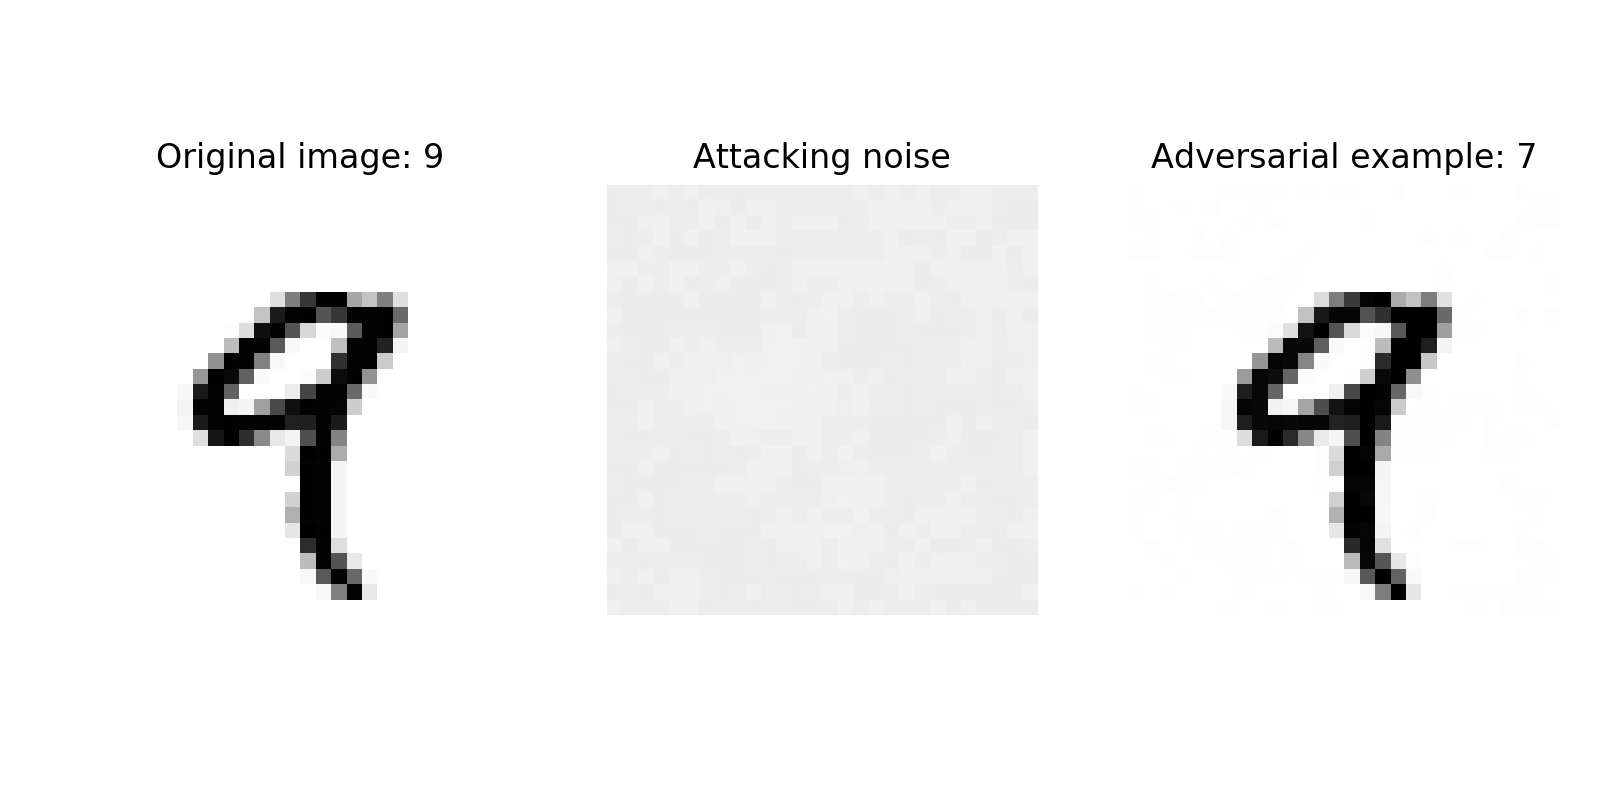

In [75]:
fgn_model.set_random_eval(True)
model = classic_model
input_data = cln_data[4]
max_noise = float(max_pix-min_pix)/64.0
step_size = float(max_pix-min_pix)/128.0
print(step_size)
steps = 10

adv_img, noise, results = FGSM_attack_untargeted(model=model, input_data=input_data, data_bounds=(min_pix, max_pix),
                                                 max_noise=max_noise, loss_func=nn.CrossEntropyLoss(), 
                                                 step_size=step_size, steps=steps, confidence_req=0.99,
                                                 verbose=True)
print(results)
print(noise.min(), noise.max())
draw_result(model, input_data, noise, adv_img)

In [40]:
# # values to show:
# fgn_model.set_random_eval(True)
# model = classic_model/ FGN
# input_data = cln_data[103]
# max_noise = float(max_pix-min_pix)/64.0
# step_size = float(max_pix-min_pix)/100.0
# steps = 1000
# Classic finds adversarial right away, FGN takes time

# cln_data[103]: fgn can't reach same confidence

# 107, max_noise=/128: FGN finds adv but not classic
# 109: FGN fails because it's already class 2, dominant class. Classic finds an adv.

In [31]:
loss_track = []

In [32]:
# import torch
from torch.autograd import Variable
from torch.autograd.gradcheck import zero_gradients
# import fgn_helper_lib as fgnh

def FGSM_attack_targeted(model, input_data, target_class, max_noise, loss_func, step_size, data_bounds,
                         steps=1, confidence_req=0.5,
                         **kwargs):
    # fast gradient sign method
    # returns an adversarial noise for this input (and the adversarial input that goes with the noise)
    # assumes the argmax index of the output is the prediction
    # currently only uses inf-norm as measure of the noise amplitude
    # in original paper, steps = 1!
    # changes to original paper/code: 
    # - attempt to increase confidence on target class by changing step size
    # - if zero grad found, takes random step
    
    # model: a pytorch model that outputs a raw vector for a N-class prediction
    if not isinstance(model, torch.nn.Module):
        raise TypeError("model is not pytorch module")
    # input_data: a tensor accepted by the model 
    if not isinstance(input_data, torch.Tensor):
        raise TypeError("input is not a pytorch tensor")
    
    # target_class: int representing the target class
    
    # max_noise: positive float, maximum change allowed in each input dimension
    
    # loss_func: the loss function used to compute the adversarial gradients
    
    # step_size: espilon on rest of literature 
    
    # data_min, data_max: boundaries for data values (to be updated to a min/max for each dim? )
    data_min, data_max = min(data_bounds), max(data_bounds)
    
    # steps: integer number of steps of gradient compute
    
    # confidence_req: require that the confidence of the adversarial pred be higher than this
    
    ### kwargs    
    # verbose: boolean, used to print training stats
    verbose = kwargs['verbose'] if 'verbose' in kwargs else False
    # device: a pytorch device, used to tell where to run the model
    if 'device' in kwargs:
        # check device type
        if not isinstance(kwargs['device'], torch.device):
            raise TypeError("device is not pytorch device")
        # give warning
        if verbose: print("Warning: device specified. This might change model and input location (cuda<->cpu)")
        device = kwargs['device']
        change_device = True
    else:
        # get device from module (will run into probs if on multiple gpus)
        device = next(model.parameters()).device
        change_device = False
    
    # send model to device
    if change_device:
            model.to(device)
            
    # send input to device
#     input_data = input_data.to(device)
    
    # set model to eval mode
    model.eval()
    
    # get prediction for input (int)
    # this might even be the wrong class, but the attack aims to change this prediction
    orig_class = fgnh.get_class_from_pred(model, input_data, **kwargs)    
       
    ### start of attack code
    cur_best_confidence = -1.0
    print_once = True
        
    # variables to return
    adv_input = input_data
    cur_best_adv = adv_input
    adv_noise = torch.zeros_like(cur_best_adv)
    cur_best_noise = torch.zeros_like(cur_best_adv)
    target_class_tensor = torch.Tensor([target_class]).long().to(device)
    # current adv_input (this is the leaf var for which we keep the grads)
    cur_adv_input = Variable(input_data, requires_grad=True)
    loss_tracker = []
    
    # start of attack
    for step in range(steps):
#         if verbose: print("Step:", step)
        # reset the gradients
        zero_gradients(cur_adv_input)

        # compute model output for current adv_input
        cur_out = model(cur_adv_input)
        # set current prediction
        cur_pred = cur_out.data.max(1)[1]
        cur_class = cur_pred.cpu().numpy()[0]
#         if verbose: print("Current prediction:", cur_pred)

        confidence = torch.softmax(cur_out,1).max(1)[0].detach().cpu().numpy()[0]
        
        # check if already successful
        if (cur_class==target_class) and (confidence>=confidence_req) :
            if verbose: print("Early stopping at step {} with confidence {}:".format(step, confidence))
            cur_best_confidence = confidence
            cur_best_adv = adv_input
            cur_best_noise = adv_noise
            # exit 'for step' loop
            break
            
        # update whenever we find new best confidence in the target class
        if (cur_class==target_class):
            if (confidence>cur_best_confidence):
                if verbose and not print_once: print("New best confidence found at step {}:".format(step), confidence)
                # say if we have already have the target class, but not enough confidence            
                if print_once and verbose:
                    print("Found target class {} at step {} with confidence {}.".format(cur_class ,step, confidence))
                    print("Attempting to increase confidence")
                    print_once = False
                # update best values
                cur_best_confidence = confidence
                cur_best_adv = adv_input
                cur_best_noise = adv_noise
            else:
                # update step size when 
                step_size = 0.99*step_size #crude
            
        # if not successful yet, update steps, noise, and adv input

        # compute current loss, to be maximized for untargeted attack
        cur_loss = loss_func(cur_out, target_class_tensor)
        loss_tracker.append(cur_loss.detach().cpu().numpy())
        # apply backprob
        cur_loss.backward()
        # sign of the grad * step size
        normed_grad = step_size * torch.sign(cur_adv_input.grad.data)
        
        # if grad is zero, add tiny noise
        if (torch.abs(normed_grad).max()<=1e-32):
#             if verbose: print("Grad zero found. Taking Random Step")
            normed_grad =  step_size * torch.sign(2.0*torch.rand_like(normed_grad)-1.0)

        # step WITH the gradient
        step_adv = cur_adv_input.data - normed_grad

        # compute adv noise
        adv_noise = step_adv - input_data
        # clip to max noise
        adv_noise = torch.clamp(adv_noise, min=-max_noise, max=max_noise)

        # compute current adv input
        adv_input = input_data + adv_noise
        # clip to max and min value of dataset
        adv_input = torch.clamp(adv_input, data_min, data_max)
        # cur_adv input for grad compute 
        cur_adv_input.data = adv_input
        
    # return dict of results for analysis
    results = {'steps':step, 'confidence':cur_best_confidence, 'loss_tracker':loss_tracker}
        
    return cur_best_adv.cpu(), cur_best_noise.cpu(), results    

Found target class 9 at step 6 with confidence 0.435121953487.
Attempting to increase confidence
New best confidence found at step 8: 0.52679586
99 0.52679586
tensor(-0.2029) tensor(0.2029)


<IPython.core.display.Javascript object>


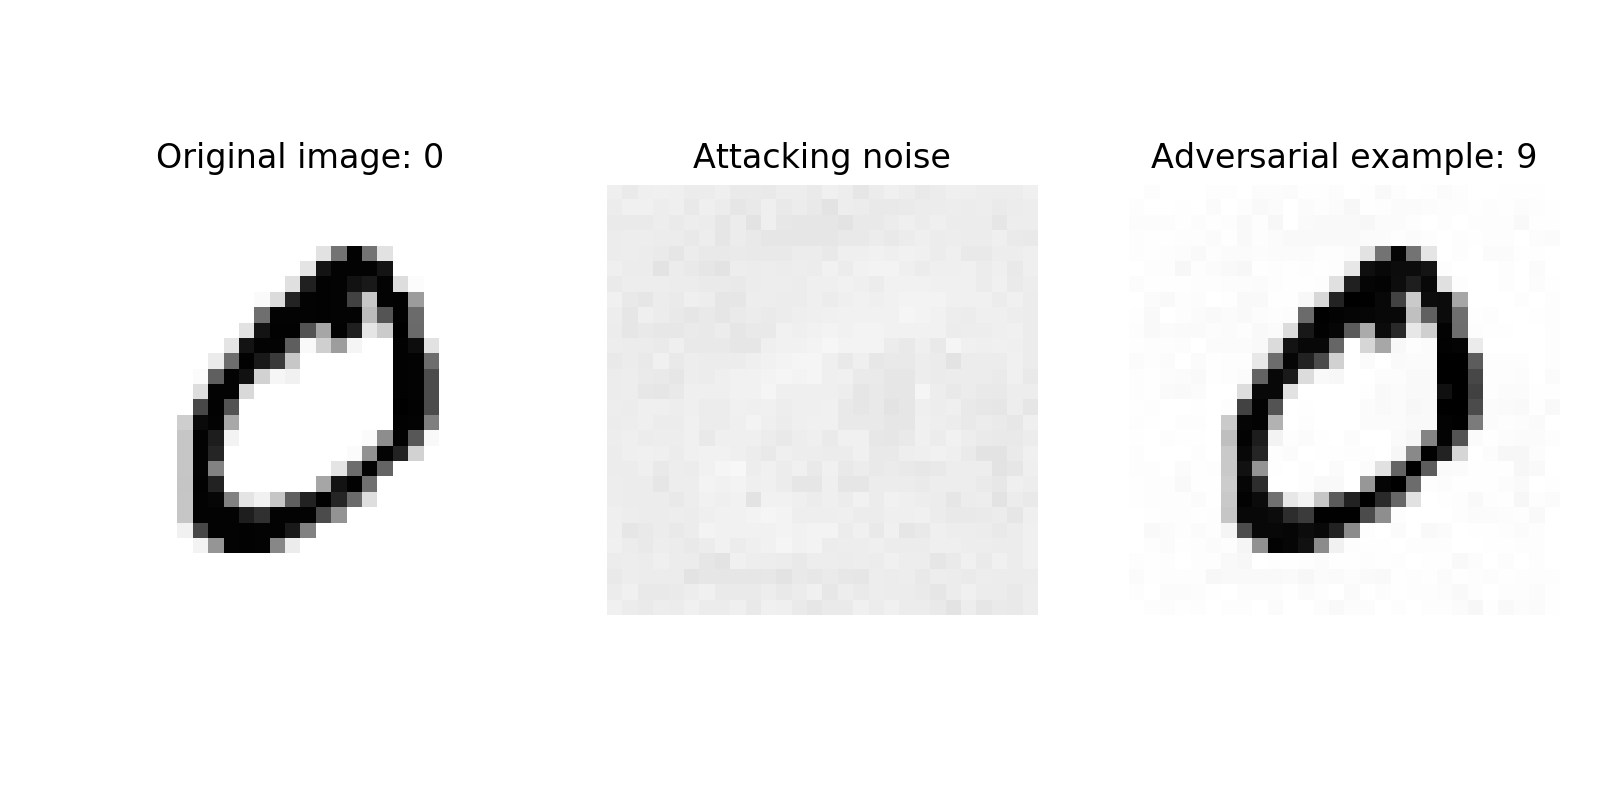

In [33]:
fgn_model.set_random_eval(True)
model = classic_model
input_data = cln_data[1]
max_noise = float(max_pix-min_pix)/16.0
step_size = float(max_pix-min_pix)/128.0
steps = 100

adv_img, noise, results = FGSM_attack_targeted(model=model, input_data=input_data, target_class=9,
                                               data_bounds=(min_pix,max_pix),
                                               max_noise=max_noise, loss_func=nn.CrossEntropyLoss(), 
                                               step_size=step_size, steps=steps, confidence_req=0.99,
                                               verbose=True)
print(results['steps'], results['confidence'])
print(noise.min(), noise.max())
draw_result(model, input_data, noise, adv_img)

<IPython.core.display.Javascript object>


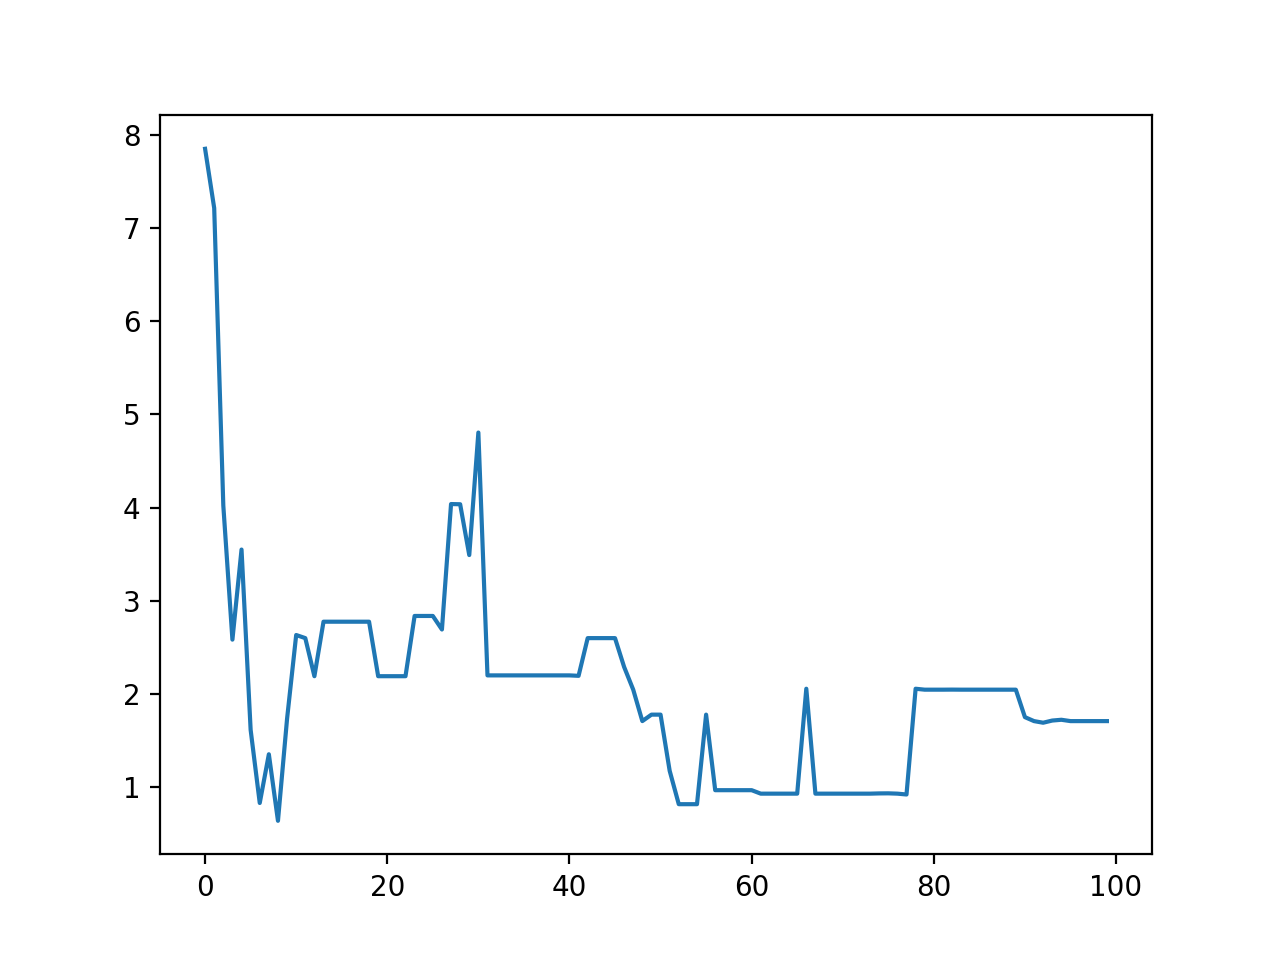

In [34]:
plt.plot(results['loss_tracker'])
plt.show()

In [35]:
# compute model output for current adv_input
cur_out = model(adv_img.to(device))
# set current prediction
cur_pred = cur_out.data.max(1)[1]
cur_class = cur_pred.cpu().numpy()[0]
#         if verbose: print("Current prediction:", cur_pred)

confidence = torch.softmax(cur_out,1).max(1)[0].detach().cpu().numpy()[0]

In [36]:
print(cur_pred)
print(confidence)

tensor([9], device='cuda:1')
0.52679586
